# Advancing Weather Forecasting: A Comparative Analysis of Long Short-Term Memory and Support Vector Machines 

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from geopy.distance import distance
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import time
from joblib import dump, load

### Loading the Dataset

In [2]:
# Load the dataset
data = pd.read_csv('aggregated_hourly_data.csv')
data = data.dropna()

### Data Transformation

In [3]:
# Calculate decimal degrees for latitude and longitude - even though there are geographical points of the data
### but for this analysis i have not used geographical points
###though i have calculated some geographical varaiables 

data['st_lat'] = data['st_lat'].apply(lambda x: int(str(x)[-2:])/3600 + int(str(x)[-4:-2])/60 + int(str(x)[:-4]))
data['st_long'] = data['st_long'].apply(lambda x: (int(str(x)[-2:])/3600 + int(str(x)[-4:-2])/60 + int(str(x)[:-4]))*(-1))
datahead = data.head(5)
datahead

,Unnamed: 0,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,...,sun,vis,clht,clamt,county,st_id,st_name,st_height,st_lat,st_long
370509,370509,2007-12-31 02:00:00,2,0.0,0,9.6,0,8.8,8.0,10.7,...,0.0,20000.0,44.0,7.0,Clare,518,shannon_airport,15,52.690278,-8.918056
370510,370510,2007-12-31 03:00:00,0,0.0,0,9.7,0,8.8,7.9,10.6,...,0.0,20000.0,50.0,4.0,Clare,518,shannon_airport,15,52.690278,-8.918056
370511,370511,2007-12-31 04:00:00,0,0.0,0,9.9,0,8.8,7.6,10.4,...,0.0,20000.0,200.0,4.0,Clare,518,shannon_airport,15,52.690278,-8.918056
370512,370512,2007-12-31 05:00:00,0,0.0,0,10.4,0,9.3,8.2,10.8,...,0.0,20000.0,60.0,7.0,Clare,518,shannon_airport,15,52.690278,-8.918056
370513,370513,2007-12-31 06:00:00,0,0.0,0,10.6,0,9.7,8.7,11.3,...,0.0,20000.0,40.0,8.0,Clare,518,shannon_airport,15,52.690278,-8.918056


In [4]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data.info()
datahead = data.head(100)
# rename columns
data.rename(columns = {'ind': 'i_rain', 'ind.1': 'i_temp', 'ind.2': 'i_wetb',
                                  'ind.3': 'i_wdsp', 'ind.4': 'i_wddir'}, inplace = True)
print('Column names: ', data.columns)
# Are all datetime values unique?
print('Unique timestamps: ', data.date.nunique())
print('All timestamps: ', data.shape[0])
# Set timestamp as an index
data.set_index('date', inplace = True)
data.head()
# Convert index to datetime objects
data.index = pd.to_datetime(data.index)
# Check for missing hours in index
print('Unique Timestamps in our data: ', data.index.nunique())
print('Total range: ', (data.index.max() - data.index.min()) / pd.Timedelta('1 hour'))

<class 'pandas.core.frame.DataFrame'>
Index: 662345 entries, 370509 to 2962034
Data columns (total 27 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       662345 non-null  object 
 1   ind        662345 non-null  int64  
 2   rain       662345 non-null  float64
 3   ind.1      662345 non-null  int64  
 4   temp       662345 non-null  float64
 5   ind.2      662345 non-null  int64  
 6   wetb       662345 non-null  float64
 7   dewpt      662345 non-null  float64
 8   vappr      662345 non-null  float64
 9   rhum       662345 non-null  float64
 10  msl        662345 non-null  float64
 11  ind.3      662345 non-null  float64
 12  wdsp       662345 non-null  float64
 13  ind.4      662345 non-null  float64
 14  wddir      662345 non-null  float64
 15  ww         662345 non-null  float64
 16  w          662345 non-null  float64
 17  sun        662345 non-null  float64
 18  vis        662345 non-null  float64
 19  clht       662345 non-


### Removing Nulls 

In [5]:
# count NAs
data.isnull().sum()
# look at rows with NAs
data[data.isna().any(axis=1)]
# fill NAs by interpolating (default method = 'linear')
data.interpolate(inplace = True)
# make sure all NAs are filled
data.isnull().sum()
# drop indicators
data.drop(columns = ['i_rain', 'i_temp', 'i_wetb', 'i_wdsp', 'i_wddir'], inplace = True)
# count unique values in each column
data.nunique()


C:\Users\Syed Muhammad Mohsin\AppData\Local\Temp\ipykernel_25792\1707903422.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(inplace = True)


rain         153
temp         426
wetb         342
dewpt        327
vappr        210
rhum          80
msl          978
wdsp          53
wddir         37
ww            74
w             71
sun           11
vis           87
clht         157
clamt         10
county         6
st_id          8
st_name        8
st_height      8
st_lat         8
st_long        8
dtype: int64

## EXPLORATORY DATA ANALYSIS

In [6]:
# look at statistics
Datadesc = data.describe().T
#Datadesc.to_excel('datadesc.xlsx')
Datadesc

,count,mean,std,min,25%,50%,75%,max
rain,662345.0,0.124380,0.497221,0.000000,0.000000,0.000000,0.000000,38.400000
temp,662345.0,9.922873,4.830016,-15.400000,6.600000,10.000000,13.400000,31.500000
wetb,662345.0,8.596542,4.525487,-49.900000,5.500000,8.900000,11.900000,22.000000
dewpt,662345.0,7.185166,4.513444,-16.400000,3.900000,7.400000,10.600000,19.900000
vappr,662345.0,10.570086,3.175379,1.700000,8.100000,10.300000,12.800000,23.200000
rhum,662345.0,84.142935,12.114841,20.000000,77.000000,87.000000,94.000000,100.000000
msl,662345.0,1013.246276,12.529400,948.200000,1005.500000,1014.400000,1021.900000,1050.000000
wdsp,662345.0,9.918461,5.575393,0.000000,6.000000,9.000000,13.000000,61.000000
wddir,662345.0,200.974477,84.909557,0.000000,140.000000,220.000000,260.000000,360.000000
ww,662345.0,17.189089,23.643263,0.000000,2.000000,2.000000,25.000000,97.000000


### Correlation Matrix

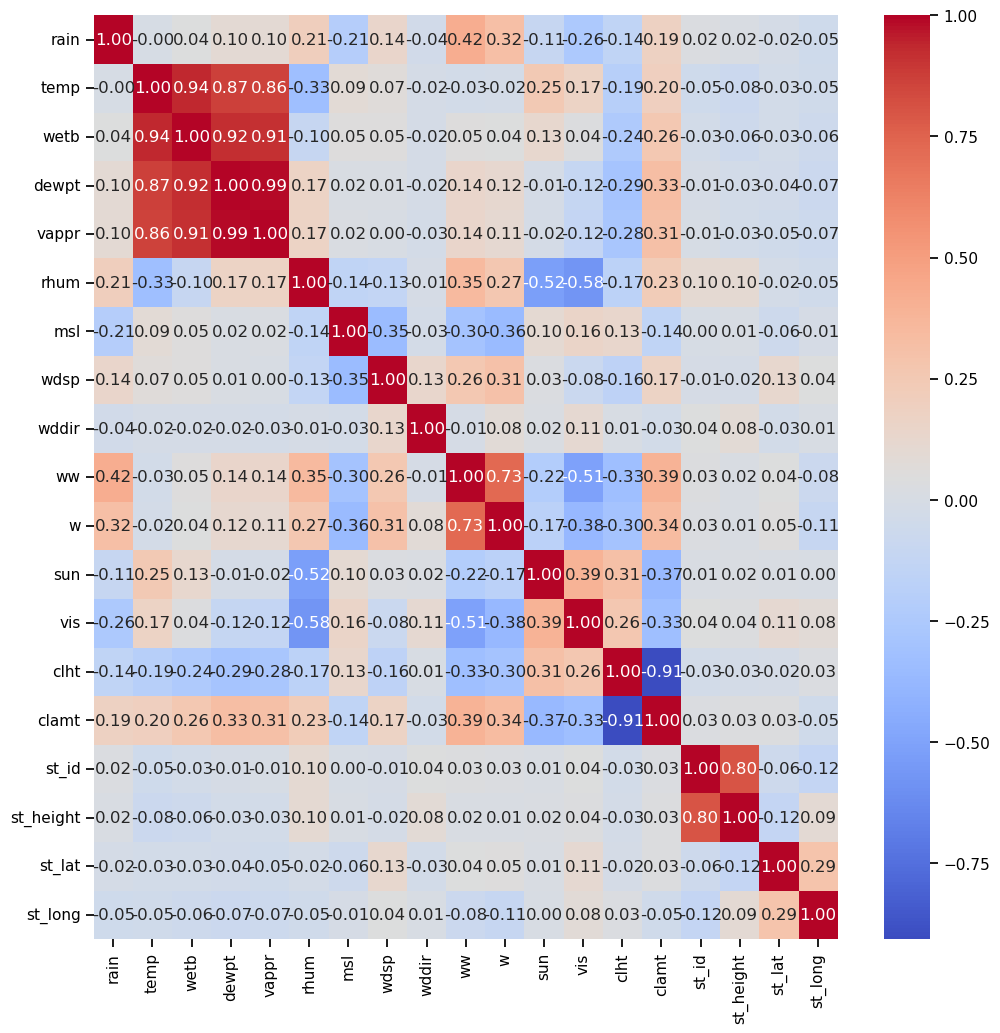

In [7]:
# Select only numeric columns for correlation analysis - excluding geographical data points
numeric_data = data.select_dtypes(include='number')
corr_matrix = numeric_data.corr()

# Look at correlations between weather variables recorded from Dublin Airport station
sns.set_context('notebook', font_scale=1)
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(data=numeric_data.corr(), annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
plt.show()



## Distribution of Variables - Transforming Data Weekly

C:\Users\Syed Muhammad Mohsin\AppData\Local\Temp\ipykernel_25792\2327037471.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


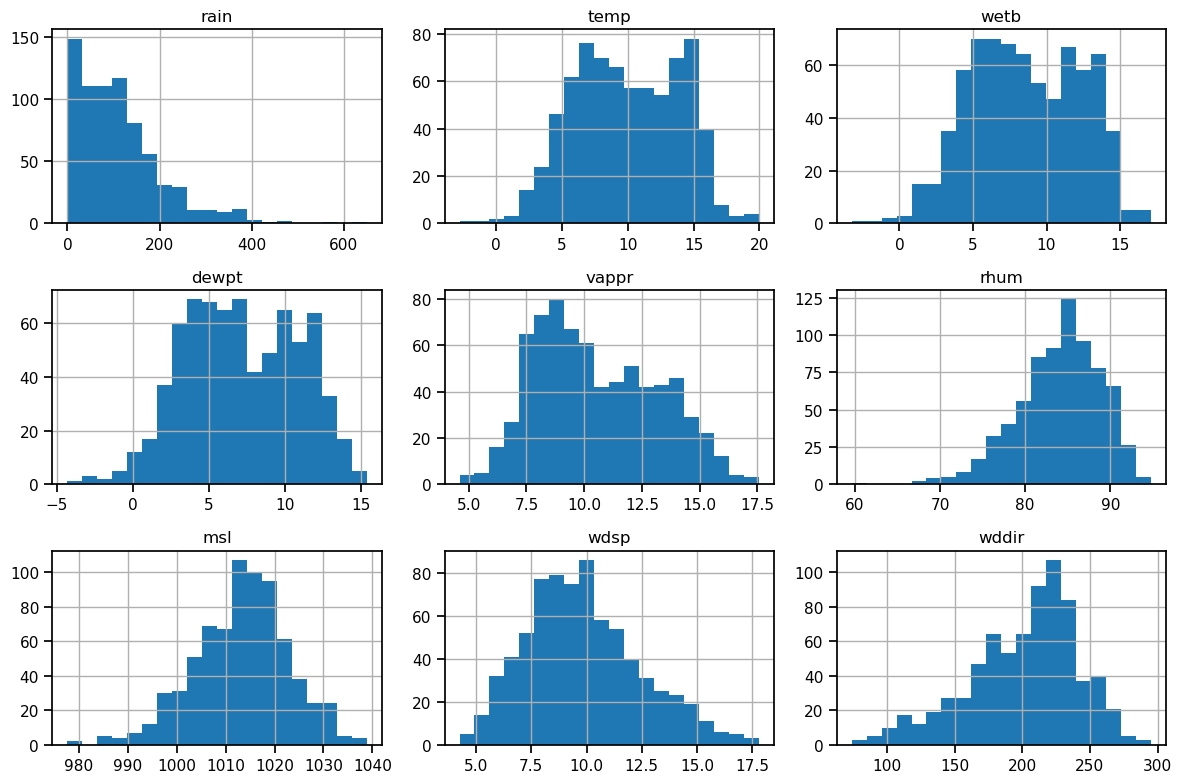

In [8]:
# making the weekly aggregated data- 
## creating aggregated weekly data to analyse the temporal trends and patterns
### making it more effective than using raw data as an input

rainfall_weekly = data[['rain']].resample('W').sum()
all_weekly = data[['temp', 'wetb', 'dewpt', 'vappr', 
                              'rhum', 'msl', 'wdsp', 'wddir']].resample('W').mean()
weekly_da = pd.concat([rainfall_weekly, all_weekly], axis = 1)
weekly_da.isna().sum()




# visualize distribution of values for each variable with histogram
fig, axList = plt.subplots(3, 3, sharex=False, sharey=False)
axList = axList.flatten()
fig.set_size_inches(12, 8)
for i,ax in enumerate(axList[0:len(weekly_da.columns)]):
    weekly_da.hist(column = weekly_da.columns[i], bins = 20, ax=ax)
            
fig.tight_layout()
fig.show()


# MODELLING
## LSTM VS SVM

### LONG-SHORT TERM MEMORY - RAINFALL FORECASTING

lr: 0.001, hidden_size: 10, epoch:   1 train_loss_rainfall: 0.07602387 val_loss_rainfall: 0.03590120 epoch_time: 1.25 seconds
lr: 0.001, hidden_size: 10, epoch:  11 train_loss_rainfall: 0.07180347 val_loss_rainfall: 0.03375670 epoch_time: 1.15 seconds
lr: 0.001, hidden_size: 10, epoch:  21 train_loss_rainfall: 0.07109370 val_loss_rainfall: 0.03324873 epoch_time: 1.23 seconds
lr: 0.001, hidden_size: 10, epoch:  31 train_loss_rainfall: 0.07083794 val_loss_rainfall: 0.03315763 epoch_time: 1.20 seconds
lr: 0.001, hidden_size: 10, epoch:  41 train_loss_rainfall: 0.07064841 val_loss_rainfall: 0.03318968 epoch_time: 1.27 seconds
lr: 0.001, hidden_size: 50, epoch:   1 train_loss_rainfall: 0.07680452 val_loss_rainfall: 0.03893052 epoch_time: 1.51 seconds
lr: 0.001, hidden_size: 50, epoch:  11 train_loss_rainfall: 0.07139355 val_loss_rainfall: 0.03340363 epoch_time: 1.43 seconds
lr: 0.001, hidden_size: 50, epoch:  21 train_loss_rainfall: 0.07077269 val_loss_rainfall: 0.03336529 epoch_time: 1.46 

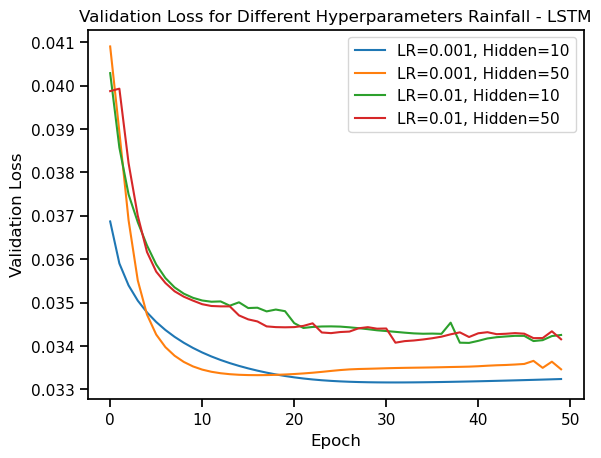

MSE Values Rainfall:
      lr  hidden_size  mse_rainfall
0  0.001           10   3550.368425
1  0.001           50   3533.907725
2  0.010           10   4174.129595
3  0.010           50   3958.486429


In [9]:
# Extract rainfall data - from the weekly data aggregated data created earlier
rainfall_data = weekly_da['rain'].values.astype(float)
# Normalize data - min max scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
rainfall_data_normalized = scaler.fit_transform(rainfall_data.reshape(-1, 1))
# Convert data to PyTorch tensors
rainfall_tensor = torch.FloatTensor(rainfall_data_normalized).view(-1)
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length:i+seq_length+1]
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

# Define sequence length
seq_length = 5
# Create sequences
xs, ys = create_sequences(rainfall_tensor, seq_length)

# Split data into training and testing sets
train_size = int(len(xs) * 0.8)
test_size = len(xs) - train_size
train_X, test_X = xs[:train_size], xs[train_size:]
train_y, test_y = ys[:train_size], ys[train_size:]

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Hyperparameters for tuning - could have used more hidden layers but computationally ineffective
learning_rates = [0.001, 0.01]
hidden_layer_sizes = [10, 50]

# Record validation losses and MSEs and Record training times
validation_losses = []
mse_values = []
training_times_rain_lstm = []

# Train models with different hyperparameters
for lr in learning_rates:
    for hidden_size in hidden_layer_sizes:
        start_time = time.time() # started time for collecting training times
        # Instantiate the model, define loss function and optimizer
        model = LSTM(hidden_layer_size=hidden_size)
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train the model with epochs set to 50
        epochs = 50
        train_losses = []
        val_losses = []

        for i in range(epochs):
            model.train()
            epoch_train_loss = 0
            # Record start time
            start_time = time.time()
            for seq, labels in zip(train_X, train_y):
                optimizer.zero_grad()
                model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                torch.zeros(1, 1, model.hidden_layer_size))

                y_pred = model(seq)

                single_loss = loss_function(y_pred, labels)
                epoch_train_loss += single_loss.item()
                single_loss.backward()
                optimizer.step()

            # Calculate epoch training time and appending epoch training time to the list
            epoch_time = time.time() - start_time
            training_times_rain_lstm.append(epoch_time)
            train_losses.append(epoch_train_loss / len(train_X))

            model.eval()
            epoch_val_loss = 0
            with torch.no_grad():
                for seq, labels in zip(test_X, test_y):
                    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                    torch.zeros(1, 1, model.hidden_layer_size))

                    y_pred = model(seq)
                    val_loss = loss_function(y_pred, labels)
                    epoch_val_loss += val_loss.item()

                # Record validation loss
                val_losses.append(epoch_val_loss / len(test_X))

            if i % 10 == 1:
                print(f'lr: {lr}, hidden_size: {hidden_size}, epoch: {i:3} train_loss_rainfall: {train_losses[-1]:10.8f} val_loss_rainfall: {val_losses[-1]:10.8f} epoch_time: {epoch_time:.2f} seconds')

        validation_losses.append(val_losses)

        # Make predictions using the trained model lstm-rainfall
        model.eval()
        test_predictions = []
        for seq in test_X:
            with torch.no_grad():
                model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                                torch.zeros(1, 1, model.hidden_layer_size))
                test_predictions.append(model(seq).item())

        # Inverse transform the predictions
        test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
        # Calculate MSE for rainfall
        mse_rainfall = ((scaler.inverse_transform(test_y.reshape(-1, 1)) - test_predictions) ** 2).mean()
        mse_values.append({
            'lr': lr,
            'hidden_size': hidden_size,
            'mse_rainfall': mse_rainfall
        })

# Plot validation loss graphs for each set of hyperparameters
for idx, (lr, hidden_size) in enumerate([(lr, hidden_size) for lr in learning_rates for hidden_size in hidden_layer_sizes]):
    plt.plot(validation_losses[idx], label=f'LR={lr}, Hidden={hidden_size}')

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for Different Hyperparameters Rainfall - LSTM')
plt.legend()
plt.show()

# Convert MSE values to DataFrame
mse_df_rain_lstm = pd.DataFrame(mse_values)
# Display the MSE values table
print("MSE Values Rainfall:")
print(mse_df_rain_lstm)

### Creating a df to save model losses ( train and validation) for comparison

In [10]:
# Create a DataFrame for hyperparameters, validation losses, and training times for LSTM - rainfall
lstm_data = []
for lr in learning_rates:
    for hidden_size in hidden_layer_sizes:
        idx = learning_rates.index(lr) * len(hidden_layer_sizes) + hidden_layer_sizes.index(hidden_size)
        lstm_data.append({
            'Learning Rate': lr,
            'Hidden Size': hidden_size,
            'Validation Loss': validation_losses[idx][-1],  # Get the last validation loss for the last epoch
            'Training Time': training_times_rain_lstm[idx]  # Get the training time for this set of hyperparameters
        })

# Convert the LSTM data to a DataFrame
df_hyperparameters_lstm_rain = pd.DataFrame(lstm_data)

# Display the DataFrame
print(df_hyperparameters_lstm_rain)


   Learning Rate  Hidden Size  Validation Loss  Training Time
0          0.001           10         0.033237       1.090688
1          0.001           50         0.033461       1.254242
2          0.010           10         0.034252       1.224217
3          0.010           50         0.034153       1.120978


In [11]:
#This line of code is generated to draw the hyperparameter comparison (using a df to save model training and testing times)
#df_hyperparameters_lstm_rain.to_excel('df_hyperparameters_lstm_rain.xlsx')

### Best LSTM Model Trained with best hyperparameters - Rainfall

Best model: lr=0.001, hidden_size=10, epoch:   1 train_loss_rainfall: 0.07630340 val_loss_rainfall: 0.03624599
Best model: lr=0.001, hidden_size=10, epoch:  26 train_loss_rainfall: 0.07075860 val_loss_rainfall: 0.03347538
Best model: lr=0.001, hidden_size=10, epoch:  51 train_loss_rainfall: 0.06944639 val_loss_rainfall: 0.03419261
Best model: lr=0.001, hidden_size=10, epoch:  76 train_loss_rainfall: 0.06772627 val_loss_rainfall: 0.03409336


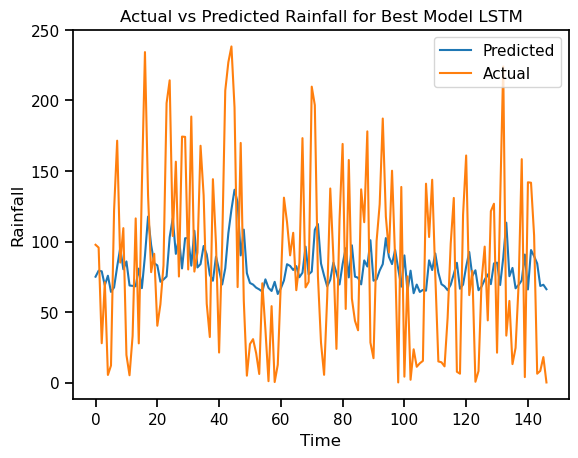

In [12]:
# Find the index of the minimum validation loss
best_index = np.unravel_index(np.argmin(validation_losses), np.array(validation_losses).shape)
best_lr_index = best_index[0] // len(hidden_layer_sizes)
best_hidden_size_index = best_index[0] % len(hidden_layer_sizes)
best_lr = learning_rates[best_lr_index]
best_hidden_size = hidden_layer_sizes[best_hidden_size_index]

# Instantiate the best model with the best hyperparameters
best_model_lstm_rainfall = LSTM(hidden_layer_size=best_hidden_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(best_model_lstm_rainfall.parameters(), lr=best_lr)

# Train the best model 
## Train the best model lstm rainfall over best set of hyperparameters deduced earlier - on 100 epochs 
epochs = 100
best_train_losses = []
best_val_losses = []

for i in range(epochs):
    best_model_lstm_rainfall.train()
    epoch_train_loss = 0
    for seq, labels in zip(train_X, train_y):
        optimizer.zero_grad()
        best_model_lstm_rainfall.hidden_cell = (torch.zeros(1, 1, best_model_lstm_rainfall.hidden_layer_size),
                        torch.zeros(1, 1, best_model_lstm_rainfall.hidden_layer_size))

        y_pred = best_model_lstm_rainfall(seq)

        single_loss = loss_function(y_pred, labels)
        epoch_train_loss += single_loss.item()
        single_loss.backward()
        optimizer.step()

    best_train_losses.append(epoch_train_loss / len(train_X))

    best_model_lstm_rainfall.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for seq, labels in zip(test_X, test_y):
            best_model_lstm_rainfall.hidden_cell = (torch.zeros(1, 1, best_model_lstm_rainfall.hidden_layer_size),
                            torch.zeros(1, 1, best_model_lstm_rainfall.hidden_layer_size))

            y_pred = best_model_lstm_rainfall(seq)
            val_loss = loss_function(y_pred, labels)
            epoch_val_loss += val_loss.item()

        # Record validation loss
        best_val_losses.append(epoch_val_loss / len(test_X))

    if i % 25 == 1:
        print(f'Best model: lr={best_lr}, hidden_size={best_hidden_size}, epoch: {i:3} train_loss_rainfall: {best_train_losses[-1]:10.8f} val_loss_rainfall: {best_val_losses[-1]:10.8f}')

# Make predictions using the best model
best_model_lstm_rainfall.eval()
best_test_predictions_rain_lstm = []
for seq in test_X:
    with torch.no_grad():
        best_model_lstm_rainfall.hidden = (torch.zeros(1, 1, best_model_lstm_rainfall.hidden_layer_size),
                        torch.zeros(1, 1, best_model_lstm_rainfall.hidden_layer_size))
        best_test_predictions_rain_lstm.append(best_model_lstm_rainfall(seq).item())

# Inverse transform the predictions
best_test_predictions_rain_lstm = scaler.inverse_transform(np.array(best_test_predictions_rain_lstm).reshape(-1, 1))

# Plot actual vs predicted for the best model
plt.plot(best_test_predictions_rain_lstm, label='Predicted')
plt.plot(scaler.inverse_transform(test_y.reshape(-1, 1)), label='Actual')
plt.xlabel('Time')
plt.ylabel('Rainfall')
plt.title('Actual vs Predicted Rainfall for Best Model LSTM')
plt.legend()
plt.show()

### Saving the test file

In [13]:
# Save the test data as a NumPy file
np.save('test_X.npy', test_X)

### Saving the Model-LSTM_Rainfall

In [14]:
### SAVING THE MODEL- LSTM
# Save the best model as a joblib file
dump(best_model_lstm_rainfall, 'best_model_lstm_rainfall.joblib')

# Load the best model from the joblib file ( if needed)
#loaded_model = load('best_model_lstm_rainfall.joblib')

# Load the test data from the NumPy file
#loaded_test_X = np.load('test_X.npy')



## to use this test text convert to the test to pytorch tensor to be utilized


['best_model_lstm_rainfall.joblib']

## LONG-SHORT TERM MEMORY - TEMPERATURE FORECASTING

lr: 0.001, hidden_size: 10, epoch:   1 train_loss_temperature: 0.03826221 val_loss_temperature: 0.03296080  epoch_time: 1.16 seconds
lr: 0.001, hidden_size: 10, epoch:  11 train_loss_temperature: 0.02787560 val_loss_temperature: 0.02870887  epoch_time: 1.15 seconds
lr: 0.001, hidden_size: 10, epoch:  21 train_loss_temperature: 0.02729108 val_loss_temperature: 0.02813397  epoch_time: 1.13 seconds
lr: 0.001, hidden_size: 10, epoch:  31 train_loss_temperature: 0.02702738 val_loss_temperature: 0.02783833  epoch_time: 1.14 seconds
lr: 0.001, hidden_size: 10, epoch:  41 train_loss_temperature: 0.02683518 val_loss_temperature: 0.02758594  epoch_time: 1.16 seconds
lr: 0.001, hidden_size: 50, epoch:   1 train_loss_temperature: 0.03464158 val_loss_temperature: 0.03459286  epoch_time: 1.41 seconds
lr: 0.001, hidden_size: 50, epoch:  11 train_loss_temperature: 0.02823700 val_loss_temperature: 0.02934927  epoch_time: 1.39 seconds
lr: 0.001, hidden_size: 50, epoch:  21 train_loss_temperature: 0.0273

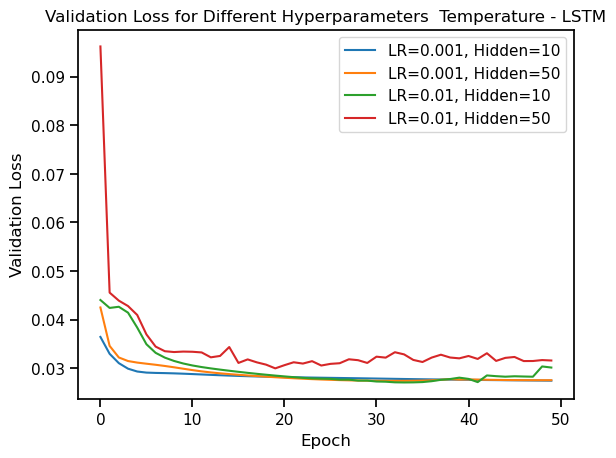

MSE Values:
      lr  hidden_size  mse_temperature
0  0.001           10         3.741914
1  0.001           50         3.683452
2  0.010           10         4.937453
3  0.010           50         5.029695


In [15]:
# Extract temperature data
temperature_data = weekly_da['temp'].values.astype(float)

# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
temperature_data_normalized = scaler.fit_transform(temperature_data.reshape(-1, 1))

# Convert data to PyTorch tensors
temperature_tensor = torch.FloatTensor(temperature_data_normalized).view(-1)

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length:i+seq_length+1]
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

# Define sequence length
seq_length = 5

# Create sequences
xs, ys = create_sequences(temperature_tensor, seq_length)

# Split data into training and testing sets
train_size = int(len(xs) * 0.8)
test_size = len(xs) - train_size
train_X, test_X = xs[:train_size], xs[train_size:]
train_y, test_y = ys[:train_size], ys[train_size:]

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Hyperparameters for tuning
learning_rates = [0.001, 0.01]
hidden_layer_sizes = [10, 50]

# Record validation losses and MSEs
validation_losses = []
mse_values = []
# Record training times
training_times_temp_lstm = []

# Train models with different hyperparameters
for lr in learning_rates:
    for hidden_size in hidden_layer_sizes:
        # Instantiate the model, define loss function and optimizer
        model = LSTM(hidden_layer_size=hidden_size)
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train the model
        epochs = 50
        train_losses = []
        val_losses = []

        for i in range(epochs):
            model.train()
            epoch_train_loss = 0
            # Record start time
            start_time = time.time()
            for seq, labels in zip(train_X, train_y):
                optimizer.zero_grad()
                model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                torch.zeros(1, 1, model.hidden_layer_size))

                y_pred = model(seq)

                single_loss = loss_function(y_pred, labels)
                epoch_train_loss += single_loss.item()
                single_loss.backward()
                optimizer.step()
                
                # Calculate epoch training time
            epoch_time = time.time() - start_time
           
           # Append epoch training time to the list
            training_times_temp_lstm.append(epoch_time)
            train_losses.append(epoch_train_loss / len(train_X))

            model.eval()
            epoch_val_loss = 0
            with torch.no_grad():
                for seq, labels in zip(test_X, test_y):
                    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                    torch.zeros(1, 1, model.hidden_layer_size))

                    y_pred = model(seq)
                    val_loss = loss_function(y_pred, labels)
                    epoch_val_loss += val_loss.item()

                # Record validation loss
                val_losses.append(epoch_val_loss / len(test_X))

            if i % 10 == 1:
                print(f'lr: {lr}, hidden_size: {hidden_size}, epoch: {i:3} train_loss_temperature: {train_losses[-1]:10.8f} val_loss_temperature: {val_losses[-1]:10.8f}  epoch_time: {epoch_time:.2f} seconds')
                

        validation_losses.append(val_losses)

        # Make predictions using the trained model
        model.eval()
        test_predictions = []
        for seq in test_X:
            with torch.no_grad():
                model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                                torch.zeros(1, 1, model.hidden_layer_size))
                test_predictions.append(model(seq).item())

        # Inverse transform the predictions
        test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))

        # Calculate MSE for temperature
        mse_temperature = ((scaler.inverse_transform(test_y.reshape(-1, 1)) - test_predictions) ** 2).mean() 


        mse_values.append({
            'lr': lr,
            'hidden_size': hidden_size,
            'mse_temperature': mse_temperature
        })

# Plot validation loss graphs for each set of hyperparameters
for idx, (lr, hidden_size) in enumerate([(lr, hidden_size) for lr in learning_rates for hidden_size in hidden_layer_sizes]):
    plt.plot(validation_losses[idx], label=f'LR={lr}, Hidden={hidden_size}')

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for Different Hyperparameters  Temperature - LSTM')
plt.legend()
plt.show()

# Convert MSE values to DataFrame
mse_df_temp_lstm = pd.DataFrame(mse_values)

# Display the MSE values table
print("MSE Values:")
print(mse_df_temp_lstm)

### Creating a df to save model losses ( train and validation) for comparison

In [16]:
# Create a DataFrame for hyperparameters, validation losses, and training times for LSTM
lstm_data_temp = []
for lr in learning_rates:
    for hidden_size in hidden_layer_sizes:
        idx = learning_rates.index(lr) * len(hidden_layer_sizes) + hidden_layer_sizes.index(hidden_size)
        lstm_data_temp.append({
            'Learning Rate': lr,
            'Hidden Size': hidden_size,
            'Validation Loss': validation_losses[idx][-1],  # Get the last validation loss for the last epoch
            'Training Time': training_times_rain_lstm[idx]  # Get the training time for this set of hyperparameters
        })

# Convert the LSTM data to a DataFrame
df_hyperparameters_lstm_temp = pd.DataFrame(lstm_data_temp)

# Display the DataFrame
print(df_hyperparameters_lstm_temp)

   Learning Rate  Hidden Size  Validation Loss  Training Time
0          0.001           10         0.027431       1.090688
1          0.001           50         0.027529       1.254242
2          0.010           10         0.030135       1.224217
3          0.010           50         0.031584       1.120978


In [17]:
#This line of code is generated to draw the hyperparameter comparison (using a df to save model training and testing times)
#df_hyperparameters_lstm_temp.to_excel('df_hyperparameters_lstm_temp.xlsx')

### Best LSTM Model Trained with best hyperparameters - Temperature

Best model: lr=0.01, hidden_size=10, epoch:   1 train_loss_temperature: 0.03693691 val_loss_temperature: 0.04347377
Best model: lr=0.01, hidden_size=10, epoch:  26 train_loss_temperature: 0.03041685 val_loss_temperature: 0.02793481
Best model: lr=0.01, hidden_size=10, epoch:  51 train_loss_temperature: 0.02838734 val_loss_temperature: 0.02899118
Best model: lr=0.01, hidden_size=10, epoch:  76 train_loss_temperature: 0.02470626 val_loss_temperature: 0.02907690


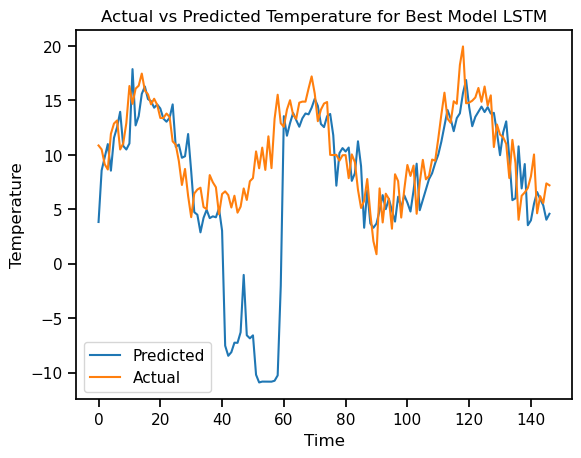

In [18]:
# Find the index of the minimum validation loss
best_index = np.unravel_index(np.argmin(validation_losses), np.array(validation_losses).shape)
best_lr_index = best_index[0] // len(hidden_layer_sizes)
best_hidden_size_index = best_index[0] % len(hidden_layer_sizes)
best_lr = learning_rates[best_lr_index]
best_hidden_size = hidden_layer_sizes[best_hidden_size_index]

# Instantiate the best model with the best hyperparameters
best_model_lstm_temp = LSTM(hidden_layer_size=best_hidden_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(best_model_lstm_temp.parameters(), lr=best_lr)

# Train the best model lstm temperature over best set of hyperparameters deduced earlier - on 100 epochs 
epochs = 100
best_train_losses = [] # calculating training losses and validation losses
best_val_losses = []

for i in range(epochs):
    best_model_lstm_temp.train()
    epoch_train_loss = 0
    for seq, labels in zip(train_X, train_y):
        optimizer.zero_grad()
        best_model_lstm_temp.hidden_cell = (torch.zeros(1, 1, best_model_lstm_temp.hidden_layer_size),
                        torch.zeros(1, 1, best_model_lstm_temp.hidden_layer_size))

        y_pred = best_model_lstm_temp(seq)

        single_loss = loss_function(y_pred, labels)
        epoch_train_loss += single_loss.item()
        single_loss.backward()
        optimizer.step()

    best_train_losses.append(epoch_train_loss / len(train_X))

    best_model_lstm_temp.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for seq, labels in zip(test_X, test_y):
            best_model_lstm_temp.hidden_cell = (torch.zeros(1, 1, best_model_lstm_temp.hidden_layer_size),
                            torch.zeros(1, 1, best_model_lstm_temp.hidden_layer_size))

            y_pred = best_model_lstm_temp(seq)
            val_loss = loss_function(y_pred, labels)
            epoch_val_loss += val_loss.item()

        # Record validation loss
        best_val_losses.append(epoch_val_loss / len(test_X))

    if i % 25 == 1:
        print(f'Best model: lr={best_lr}, hidden_size={best_hidden_size}, epoch: {i:3} train_loss_temperature: {best_train_losses[-1]:10.8f} val_loss_temperature: {best_val_losses[-1]:10.8f}')

# Make predictions using the best model
best_model_lstm_temp.eval()
best_test_predictions_lstm_temp = []
for seq in test_X:
    with torch.no_grad():
        best_model_lstm_temp.hidden = (torch.zeros(1, 1, best_model_lstm_temp.hidden_layer_size),
                        torch.zeros(1, 1, best_model_lstm_temp.hidden_layer_size))
        best_test_predictions_lstm_temp.append(best_model_lstm_temp(seq).item())

# Inverse transform the predictions
best_test_predictions_lstm_temp = scaler.inverse_transform(np.array(best_test_predictions_lstm_temp).reshape(-1, 1))

# Plot actual vs predicted for the best model
plt.plot(best_test_predictions_lstm_temp, label='Predicted')
plt.plot(scaler.inverse_transform(test_y.reshape(-1, 1)), label='Actual')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature for Best Model LSTM')
plt.legend()
plt.show()


### Saving the Model file - LSTM-Temperature

In [19]:
#Saving the model
# Save the best model as a joblib file
dump(best_model_lstm_temp, 'best_model_lstm_temp.joblib')

# Load the best model from the joblib file ( if you need loading of the model - commented out)
#loaded_model_lstm_temp = load('best_model_lstm_temp.joblib')



['best_model_lstm_temp.joblib']

# SVM

## SVM - Rainfall Forecasting

C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

MSE for Rainfall (SVM): 3602.8760644338677


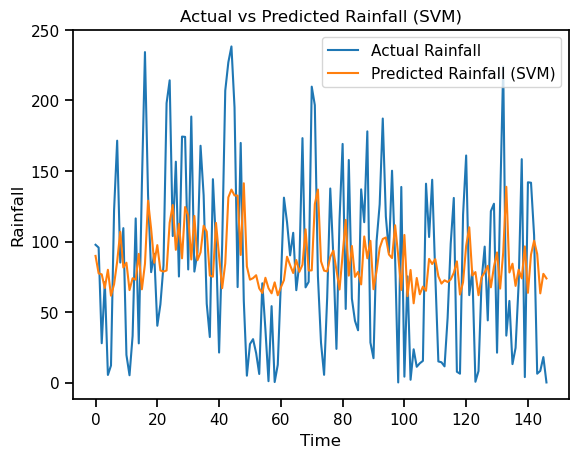

Best Hyperparameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}


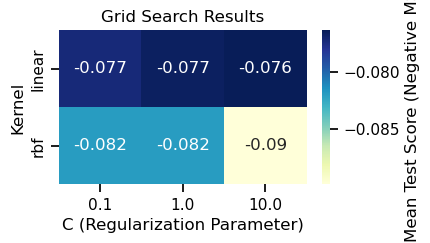

    Kernel     C  Gamma  Validation Loss  Training Time
0      rbf   0.1  scale        -0.084488       0.007221
1      rbf   0.1   auto        -0.077342       0.005333
2      rbf   1.0  scale        -0.079407       0.005712
3      rbf   1.0   auto        -0.077342       0.004985
4      rbf  10.0  scale        -0.087609       0.009035
5      rbf  10.0   auto        -0.076622       0.007643
6   linear   0.1  scale        -0.076276       0.007269
7   linear   0.1   auto        -0.076622       0.007356
8   linear   1.0  scale        -0.100665       0.020695
9   linear   1.0   auto        -0.076409       0.014989
10  linear  10.0  scale        -0.078939       0.011009
11  linear  10.0   auto        -0.076409       0.015631


In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your data loaded in 'weekly_da'

# Extract rainfall data
rainfall_data = weekly_da['rain'].values.astype(float)

# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
rainfall_data_normalized = scaler.fit_transform(rainfall_data.reshape(-1, 1))

# Define sequence length
seq_length = 5

# Create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

xs, ys = create_sequences(rainfall_data_normalized, seq_length)

# Split data into training and testing sets
train_size = int(len(xs) * 0.8)
test_size = len(xs) - train_size
train_X, test_X = xs[:train_size], xs[train_size:]
train_y, test_y = ys[:train_size], ys[train_size:]

# Flatten the sequence dimension while keeping the other dimensions intact
train_X_flat = train_X.reshape(train_X.shape[0], -1)
test_X_flat = test_X.reshape(test_X.shape[0], -1)

# Define the parameter grid
param_grid = {
    'kernel': ['rbf', 'linear'],  # Different kernel types
    'C': [0.1, 1, 10],  # Regularization parameter values
    'gamma': ['scale', 'auto']  # Gamma parameter for RBF kernel
}

# Initialize SVR model
svm_model = SVR()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(train_X_flat, train_y)

# Get the best model
best_svm_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
svm_predictions = best_svm_model.predict(test_X_flat)

# Inverse transform the predictions
svm_predictions_inv = scaler.inverse_transform(svm_predictions.reshape(-1, 1))
test_y_inv = scaler.inverse_transform(test_y.reshape(-1, 1))

# Calculate Mean Squared Error (MSE) for rainfall
mse_rainfall_svm = mean_squared_error(test_y_inv, svm_predictions_inv)
print("MSE for Rainfall (SVM):", mse_rainfall_svm)

# Plot predictions vs actual rainfall
plt.plot(test_y_inv, label='Actual Rainfall')
plt.plot(svm_predictions_inv, label='Predicted Rainfall (SVM)')
plt.xlabel('Time')
plt.ylabel('Rainfall')
plt.title('Actual vs Predicted Rainfall (SVM)')
plt.legend()
plt.show()

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Extract grid search results
results = pd.DataFrame(grid_search.cv_results_)

# Pivot the dataframe to have hyperparameters as columns
pivot_table = results.pivot_table(index='param_kernel', columns='param_C', values='mean_test_score', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mean Test Score (Negative MSE)'})
plt.title("Grid Search Results")
plt.xlabel("C (Regularization Parameter)")
plt.ylabel("Kernel")
plt.show()

# Create a DataFrame for hyperparameters, validation losses, and training times
svm_data = []
for kernel in param_grid['kernel']:
    for C in param_grid['C']:
        for gamma in param_grid['gamma']:
            idx = param_grid['kernel'].index(kernel) * len(param_grid['C']) * len(param_grid['gamma']) + \
                  param_grid['C'].index(C) * len(param_grid['gamma']) + param_grid['gamma'].index(gamma)
            svm_data.append({
                'Kernel': kernel,
                'C': C,
                'Gamma': gamma,
                'Validation Loss': grid_search.cv_results_['mean_test_score'][idx],
                'Training Time': grid_search.cv_results_['mean_fit_time'][idx]
            })

df_hyperparameters_svm = pd.DataFrame(svm_data)

# Display the DataFrame
print(df_hyperparameters_svm)


In [21]:
#This line of code is generated to draw the hyperparameter comparison (using a df to save model training and testing times)
#df_hyperparameters_svm.to_excel('df_hyperparameters_svm_rain.xlsx')

## SVM - Temperature Forecasting

C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE for Temperature (SVM): 3.5063773157897056


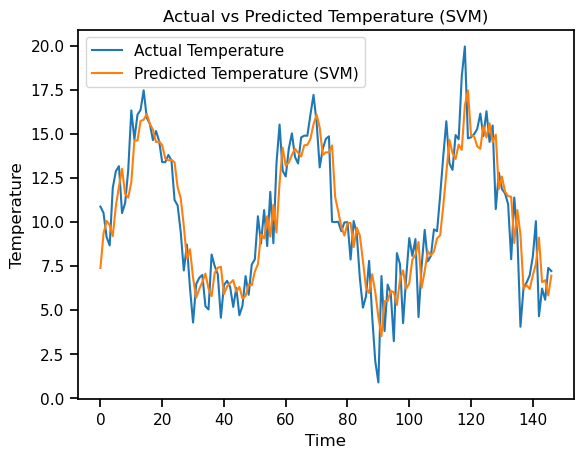

Best Hyperparameters for Temperature: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}


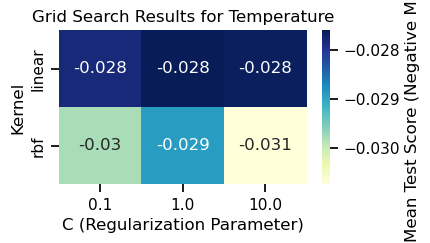

    Kernel     C  Gamma  Validation Loss  Training Time
0      rbf   0.1  scale        -0.031030       0.004668
1      rbf   0.1   auto        -0.027808       0.003674
2      rbf   1.0  scale        -0.028554       0.004379
3      rbf   1.0   auto        -0.027808       0.003957
4      rbf  10.0  scale        -0.030811       0.007997
5      rbf  10.0   auto        -0.027592       0.008041
6   linear   0.1  scale        -0.026985       0.005362
7   linear   0.1   auto        -0.027592       0.007663
8   linear   1.0  scale        -0.033502       0.015662
9   linear   1.0   auto        -0.027631       0.014617
10  linear  10.0  scale        -0.028005       0.009333
11  linear  10.0   auto        -0.027631       0.017263


In [22]:
# Extract temperature data
temperature_data = weekly_da['temp'].values.astype(float)

# Normalize data
scaler_temp = MinMaxScaler(feature_range=(-1, 1))
temperature_data_normalized = scaler_temp.fit_transform(temperature_data.reshape(-1, 1))

# Create sequences for temperature
xs_temp, ys_temp = create_sequences(temperature_data_normalized, seq_length)

# Split data into training and testing sets for temperature
train_size_temp = int(len(xs_temp) * 0.8)
test_size_temp = len(xs_temp) - train_size_temp
train_X_temp, test_X_temp = xs_temp[:train_size_temp], xs_temp[train_size_temp:]
train_y_temp, test_y_temp = ys_temp[:train_size_temp], ys_temp[train_size_temp:]

# Flatten the sequence dimension while keeping the other dimensions intact for temperature
train_X_flat_temp = train_X_temp.reshape(train_X_temp.shape[0], -1)
test_X_flat_temp = test_X_temp.reshape(test_X_temp.shape[0], -1)

# Perform grid search with cross-validation for temperature
grid_search_temp = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_temp.fit(train_X_flat_temp, train_y_temp)

# Get the best model for temperature
best_svm_model_temp = grid_search_temp.best_estimator_

# Make predictions on the test set using the best model for temperature
svm_predictions_temp = best_svm_model_temp.predict(test_X_flat_temp)

# Inverse transform the predictions for temperature
svm_predictions_inv_temp = scaler_temp.inverse_transform(svm_predictions_temp.reshape(-1, 1))
test_y_inv_temp = scaler_temp.inverse_transform(test_y_temp.reshape(-1, 1))

# Calculate Mean Squared Error (MSE) for temperature
mse_temperature_svm = mean_squared_error(test_y_inv_temp, svm_predictions_inv_temp)
print("MSE for Temperature (SVM):", mse_temperature_svm)

# Plot predictions vs actual temperature
plt.plot(test_y_inv_temp, label='Actual Temperature')
plt.plot(svm_predictions_inv_temp, label='Predicted Temperature (SVM)')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Temperature (SVM)')
plt.legend()
plt.show()

# Get the best hyperparameters for temperature
best_params_temp = grid_search_temp.best_params_
print("Best Hyperparameters for Temperature:", best_params_temp)

# Extract grid search results for temperature
results_temp = pd.DataFrame(grid_search_temp.cv_results_)

# Pivot the dataframe to have hyperparameters as columns for temperature
pivot_table_temp = results_temp.pivot_table(index='param_kernel', columns='param_C', values='mean_test_score', aggfunc='mean')

# Plot the heatmap for temperature
plt.figure(figsize=(4, 2))
sns.heatmap(pivot_table_temp, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mean Test Score (Negative MSE)'})
plt.title("Grid Search Results for Temperature")
plt.xlabel("C (Regularization Parameter)")
plt.ylabel("Kernel")
plt.show()

# Create a DataFrame for hyperparameters, validation losses, and training times for temperature
svm_data_temp = []
for kernel in param_grid['kernel']:
    for C in param_grid['C']:
        for gamma in param_grid['gamma']:
            idx = param_grid['kernel'].index(kernel) * len(param_grid['C']) * len(param_grid['gamma']) + \
                  param_grid['C'].index(C) * len(param_grid['gamma']) + param_grid['gamma'].index(gamma)
            svm_data_temp.append({
                'Kernel': kernel,
                'C': C,
                'Gamma': gamma,
                'Validation Loss': grid_search_temp.cv_results_['mean_test_score'][idx],
                'Training Time': grid_search_temp.cv_results_['mean_fit_time'][idx]
            })

df_hyperparameters_svm_temp = pd.DataFrame(svm_data_temp)

# Display the DataFrame for temperature
print(df_hyperparameters_svm_temp)

#This line of code is generated to draw the hyperparameter comparison (using a df to save model training and testing times)
#df_hyperparameters_svm_temp.to_excel('df_hyperparameters_svm_temp.xlsx')



### Saving the Model files for SVM - Rainfall & Temperature

In [26]:
# Save the best SVM model for rainfall prediction
dump(best_svm_model, 'best_svm_model_rainfall.joblib')

# Save the best SVM model for temperature prediction
dump(best_svm_model_temp, 'best_svm_model_temperature.joblib')


['best_svm_model_temperature.joblib']

## Results and Findings - SVM VS LSTM

### MSE PLOTS - Rainfall and Temperature

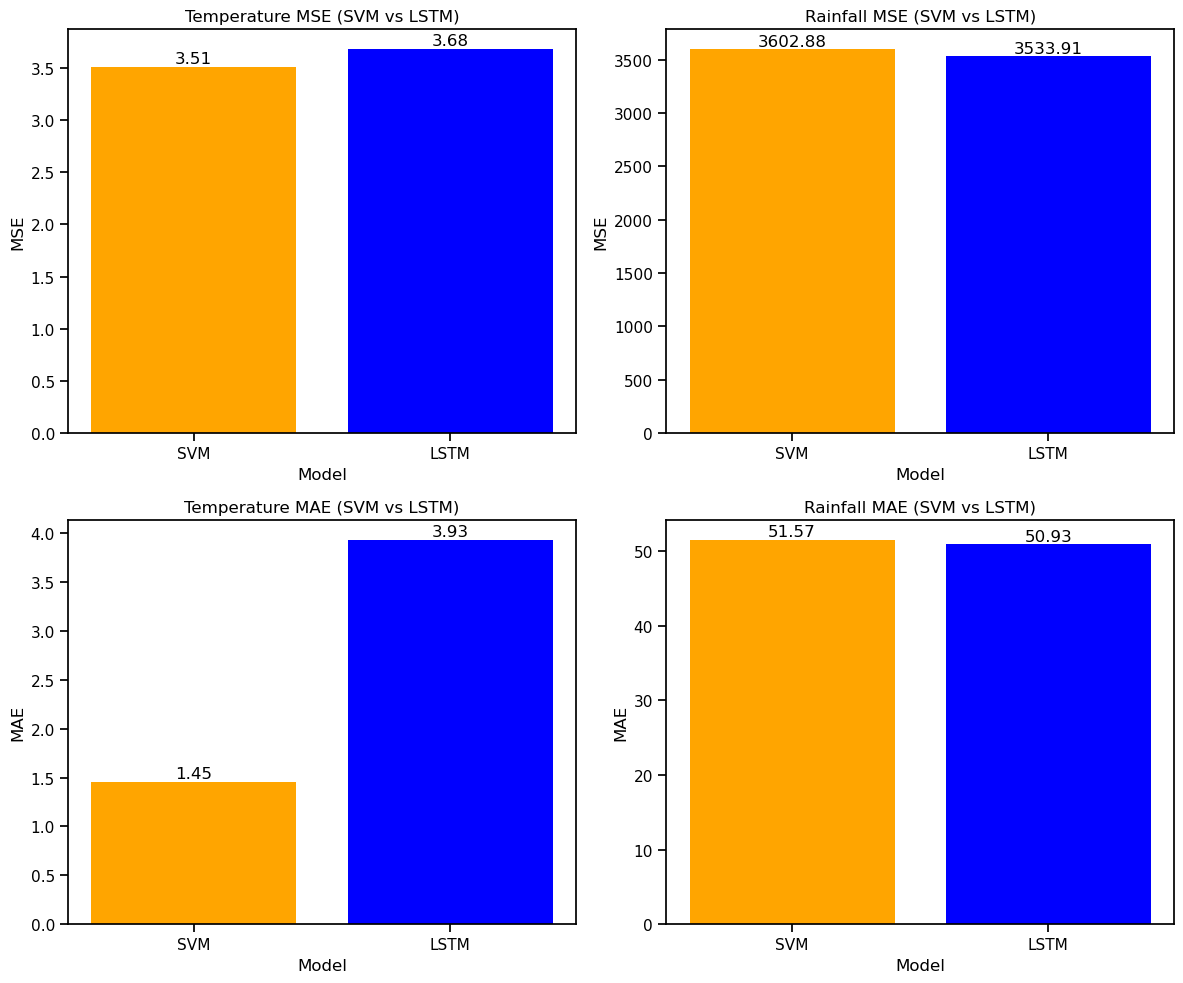

In [24]:
# Calculate Mean Absolute Error (MAE) for rainfall predictions
mae_rainfall_svm = mean_absolute_error(test_y_inv, svm_predictions_inv)
mae_rainfall_lstm = mean_absolute_error(test_y_inv, best_test_predictions_rain_lstm)

# Calculate Mean Absolute Error (MAE) for temperature predictions
mae_temperature_svm = mean_absolute_error(test_y_inv_temp, svm_predictions_inv_temp)
mae_temperature_lstm = mean_absolute_error(test_y_inv_temp, best_test_predictions_lstm_temp)

# Calculate the MSE values for SVM models for temperature and rainfall predictions
lowest_temp_svm = mse_temperature_svm
lowest_rain_svm = mse_rainfall_svm

# Calculate the MSE values for LSTM models for temperature and rainfall predictions
lowest_temp_lstm = mse_df_temp_lstm['mse_temperature'].min()
lowest_rain_lstm = mse_df_rain_lstm['mse_rainfall'].min()

# Plotting subplots for MSE and MAE comparison for temperature and rainfall
# Create a figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Temperature MSE comparison
axs[0, 0].bar(['SVM', 'LSTM'], [lowest_temp_svm, lowest_temp_lstm], color=['orange', 'blue'])
axs[0, 0].set_xlabel('Model')
axs[0, 0].set_ylabel('MSE')
axs[0, 0].set_title('Temperature MSE (SVM vs LSTM)')
# Annotate values
for i, v in enumerate([lowest_temp_svm, lowest_temp_lstm]):
    axs[0, 0].text(i, v + 0.01, str(round(v, 2)), ha='center', va='bottom')

# Rainfall MSE comparison
axs[0, 1].bar(['SVM', 'LSTM'], [lowest_rain_svm, lowest_rain_lstm], color=['orange', 'blue'])
axs[0, 1].set_xlabel('Model')
axs[0, 1].set_ylabel('MSE')
axs[0, 1].set_title('Rainfall MSE (SVM vs LSTM)')
# Annotate values
for i, v in enumerate([lowest_rain_svm, lowest_rain_lstm]):
    axs[0, 1].text(i, v + 0.01, str(round(v, 2)), ha='center', va='bottom')

# Temperature MAE comparison
axs[1, 0].bar(['SVM', 'LSTM'], [mae_temperature_svm, mae_temperature_lstm], color=['orange', 'blue'])
axs[1, 0].set_xlabel('Model')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].set_title('Temperature MAE (SVM vs LSTM)')
# Annotate values
for i, v in enumerate([mae_temperature_svm, mae_temperature_lstm]):
    axs[1, 0].text(i, v + 0.01, str(round(v, 2)), ha='center', va='bottom')

# Rainfall MAE comparison
axs[1, 1].bar(['SVM', 'LSTM'], [mae_rainfall_svm, mae_rainfall_lstm], color=['orange', 'blue'])
axs[1, 1].set_xlabel('Model')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].set_title('Rainfall MAE (SVM vs LSTM)')
# Annotate values
for i, v in enumerate([mae_rainfall_svm, mae_rainfall_lstm]):
    axs[1, 1].text(i, v + 0.01, str(round(v, 2)), ha='center', va='bottom')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


### Residual plots - SVM VS LSTM

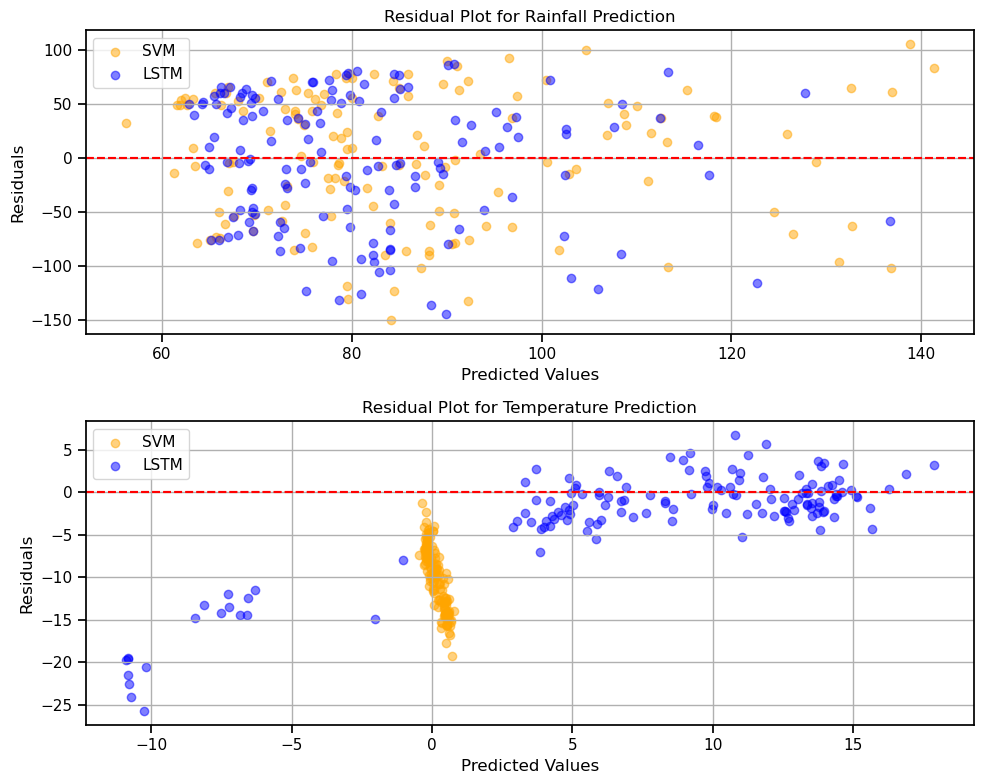

In [25]:
# Calculate residuals for SVM temperature prediction
residuals_svm_temp = svm_predictions_temp - test_y_inv_temp.flatten()
residuals_svm_rain = svm_predictions_inv.flatten() - test_y_inv.flatten()
# Calculate residuals for LSTM temperature prediction
best_test_predictions_lstm_temp = best_test_predictions_lstm_temp.flatten()
residuals_lstm_temp = best_test_predictions_lstm_temp - test_y_inv_temp.flatten()
best_test_predictions_rain_lstm = best_test_predictions_rain_lstm.flatten()
test_y_inv_rain = scaler.inverse_transform(test_y.reshape(-1, 1))
residuals_rain_lstm = best_test_predictions_rain_lstm.flatten() - test_y_inv_rain.flatten()
# Create a figure with subplots for rainfall and temperature predictions
plt.figure(figsize=(10, 8))
# Subplot for rainfall predictions
plt.subplot(2, 1, 1)

# Residual plot for SVM rainfall prediction
plt.scatter(svm_predictions_inv, residuals_svm_rain, color='orange', alpha=0.5, label='SVM')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot for Rainfall Prediction')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()

# Residual plot for LSTM rainfall prediction
plt.scatter(best_test_predictions_rain_lstm, residuals_rain_lstm, color='blue', alpha=0.5, label='LSTM')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()

# Subplot for temperature predictions
plt.subplot(2, 1, 2)

# Residual plot for SVM temperature prediction
plt.scatter(svm_predictions_temp, residuals_svm_temp, color='orange', alpha=0.5, label='SVM')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot for Temperature Prediction')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()

# Residual plot for LSTM temperature prediction
plt.scatter(best_test_predictions_lstm_temp, residuals_lstm_temp, color='blue', alpha=0.5, label='LSTM')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
